In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # To load preprocessor/feature names and save models

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # XGBoost

# Handling Imbalance (if needed)
from imblearn.over_sampling import SMOTE
# Make sure you have imbalanced-learn installed: pip install imbalanced-learn

# Pipeline (optional but good for combining SMOTE and model)
from imblearn.pipeline import Pipeline as ImbPipeline

print("Libraries imported for Classification Modeling.")

Libraries imported for Classification Modeling.


In [4]:
# Define paths to the processed data files
processed_data_dir = 'data_processed'
features_path = os.path.join(processed_data_dir, 'train_final_features.csv')
class_target_path = os.path.join(processed_data_dir, 'train_final_y_class.csv')

# Load the data
try:
    X = pd.read_csv(features_path)
    y = pd.read_csv(class_target_path).squeeze() # Use squeeze() to make y a Series, not a DataFrame
    print("Processed features and classification target loaded successfully.")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print("\nTarget distribution:")
    print(y.value_counts(normalize=True) * 100) # Check imbalance again
except FileNotFoundError as e:
    print(f"Error loading processed data files: {e}")
    print("Ensure the feature engineering notebook (3_feature_engineering.ipynb) was run successfully.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# Optional: Load feature names (useful if column order was lost, but CSV should preserve it)
# feature_names_path = '../src/models/feature_names.joblib'
# try:
#     feature_names = joblib.load(feature_names_path)
#     X.columns = feature_names # Assign column names if they were lost
#     print("Feature names loaded and assigned.")
# except FileNotFoundError:
#     print("Warning: feature_names.joblib not found. Relying on CSV header order.")

Processed features and classification target loaded successfully.
Features shape: (22910, 72)
Target shape: (22910,)

Target distribution:
purchase_completed
0    93.841117
1     6.158883
Name: proportion, dtype: float64


In [5]:
# Split data into training (80%) and testing (20%) sets
# Stratify ensures the proportion of purchase_completed (0s and 1s) is the same in train and test sets
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\nTarget distribution in Training Set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nTarget distribution in Test Set:")
print(y_test.value_counts(normalize=True) * 100)

Data split into training and testing sets.
X_train shape: (18328, 72), y_train shape: (18328,)
X_test shape: (4582, 72), y_test shape: (4582,)

Target distribution in Training Set:
purchase_completed
0    93.840026
1     6.159974
Name: proportion, dtype: float64

Target distribution in Test Set:
purchase_completed
0    93.845482
1     6.154518
Name: proportion, dtype: float64


In [9]:
print("\n--- Handling Class Imbalance using SMOTE (on Training Data) ---")

# Check imbalance before SMOTE
print("Original training set shape:", X_train.shape)
print("Original training set distribution:\n", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape after SMOTE:", X_train_smote.shape)
print("Distribution after SMOTE:\n", y_train_smote.value_counts())

# --- At the end of Step 5 cell (Handling Class Imbalance) ---

print("\n--- Handling Class Imbalance using SMOTE (on Training Data) ---")

# Check imbalance before SMOTE
print("Original training set shape:", X_train.shape)
print("Original training set distribution:\n", y_train.value_counts())

# --- Get original feature names before SMOTE ---
original_feature_names = X_train.columns.tolist()

smote = SMOTE(random_state=42)
X_train_smote_np, y_train_smote = smote.fit_resample(X_train, y_train) # fit_resample often returns numpy arrays

print("\nShape after SMOTE:", X_train_smote_np.shape)
print("Distribution after SMOTE:\n", y_train_smote.value_counts())

# --- Recreate DataFrame with original feature names ---
# This ensures we have column names associated, even if SMOTE returned numpy
X_train_smote = pd.DataFrame(X_train_smote_np, columns=original_feature_names)
print("\nRecreated X_train_smote DataFrame with columns.")

# --- Define Sanitization Function ---
import re
def sanitize_feature_names(df):
    """Removes invalid characters for XGBoost from DataFrame column names."""
    original_columns = df.columns.tolist()
    new_columns = []
    for col in original_columns:
        # Replace invalid characters with underscore or remove them
        clean_col = re.sub(r'[\[\]<]', '_', str(col))
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

# --- Sanitize feature names for X_train_smote ---
print("\nSanitizing feature names for X_train_smote...")
X_train_smote = sanitize_feature_names(X_train_smote.copy()) # Use .copy() to avoid SettingWithCopyWarning
print("X_train_smote columns after sanitization:")
print(X_train_smote.columns)

# --- ALSO Sanitize feature names for the ORIGINAL X_test ---
# Models will expect the same sanitized column names during prediction
print("\nSanitizing feature names for X_test...")
X_test = sanitize_feature_names(X_test.copy())
print("X_test columns after sanitization:")
print(X_test.columns)

# Optional: Verify X_train_smote and X_test have same columns after sanitization
if set(X_train_smote.columns) != set(X_test.columns):
     print("\nWarning: Column mismatch after sanitization! Check logic.")
     print("Train cols:", sorted(list(set(X_train_smote.columns))))
     print("Test cols:", sorted(list(set(X_test.columns))))


--- Handling Class Imbalance using SMOTE (on Training Data) ---
Original training set shape: (18328, 72)
Original training set distribution:
 purchase_completed
0    17199
1     1129
Name: count, dtype: int64

Shape after SMOTE: (34398, 72)
Distribution after SMOTE:
 purchase_completed
0    17199
1    17199
Name: count, dtype: int64

--- Handling Class Imbalance using SMOTE (on Training Data) ---
Original training set shape: (18328, 72)
Original training set distribution:
 purchase_completed
0    17199
1     1129
Name: count, dtype: int64

Shape after SMOTE: (34398, 72)
Distribution after SMOTE:
 purchase_completed
0    17199
1    17199
Name: count, dtype: int64

Recreated X_train_smote DataFrame with columns.

Sanitizing feature names for X_train_smote...
X_train_smote columns after sanitization:
Index(['session_length', 'unique_main_categories', 'unique_models_viewed',
       'unique_colours', 'avg_price_viewed', 'max_price_viewed',
       'model_photography__lambda>', 'price_2__lam


--- Training Classification Models ---

Training Logistic Regression...
Logistic Regression Training Complete.
  Accuracy: 0.8243
  Precision: 0.2361
  Recall: 0.8298
  F1-Score: 0.3676
  ROC AUC: 0.9001

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      4300
           1       0.24      0.83      0.37       282

    accuracy                           0.82      4582
   macro avg       0.61      0.83      0.63      4582
weighted avg       0.94      0.82      0.87      4582



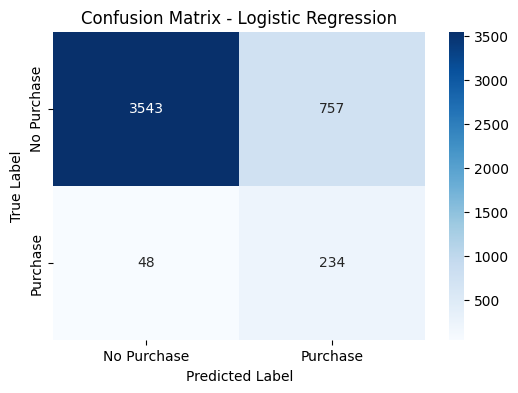


Training Decision Tree...
Decision Tree Training Complete.
  Accuracy: 0.9136
  Precision: 0.3293
  Recall: 0.3901
  F1-Score: 0.3571
  ROC AUC: 0.6695

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4300
           1       0.33      0.39      0.36       282

    accuracy                           0.91      4582
   macro avg       0.64      0.67      0.66      4582
weighted avg       0.92      0.91      0.92      4582



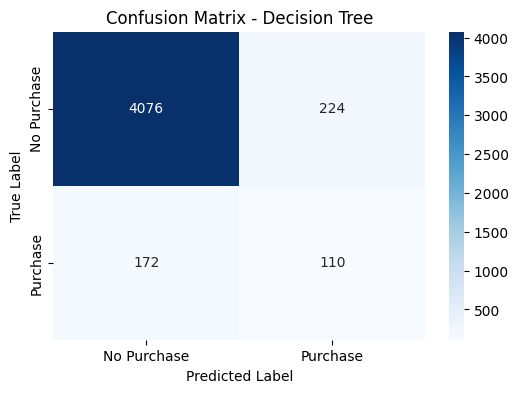


Training Random Forest...
Random Forest Training Complete.
  Accuracy: 0.9326
  Precision: 0.4502
  Recall: 0.4326
  F1-Score: 0.4412
  ROC AUC: 0.9018

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4300
           1       0.45      0.43      0.44       282

    accuracy                           0.93      4582
   macro avg       0.71      0.70      0.70      4582
weighted avg       0.93      0.93      0.93      4582



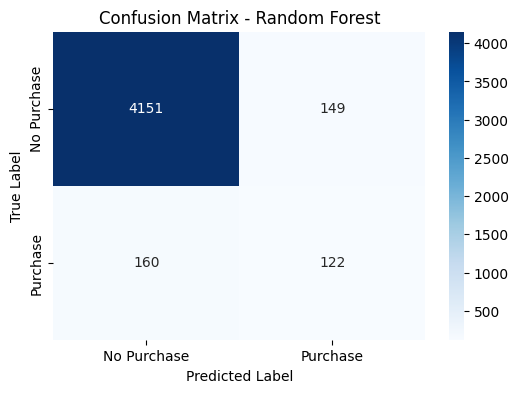


Training XGBoost...


e:\GUVI\Projects\customer_conversion_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:57:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Training Complete.
  Accuracy: 0.9470
  Precision: 0.6000
  Recall: 0.4149
  F1-Score: 0.4906
  ROC AUC: 0.9157

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4300
           1       0.60      0.41      0.49       282

    accuracy                           0.95      4582
   macro avg       0.78      0.70      0.73      4582
weighted avg       0.94      0.95      0.94      4582



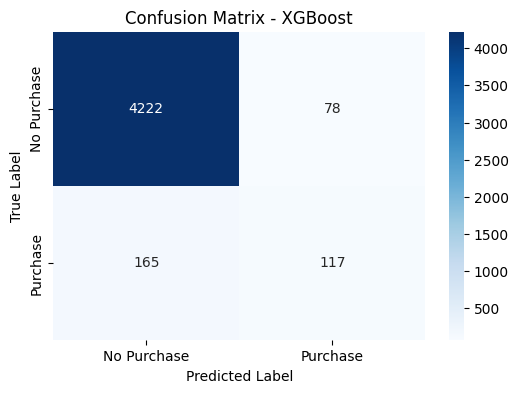

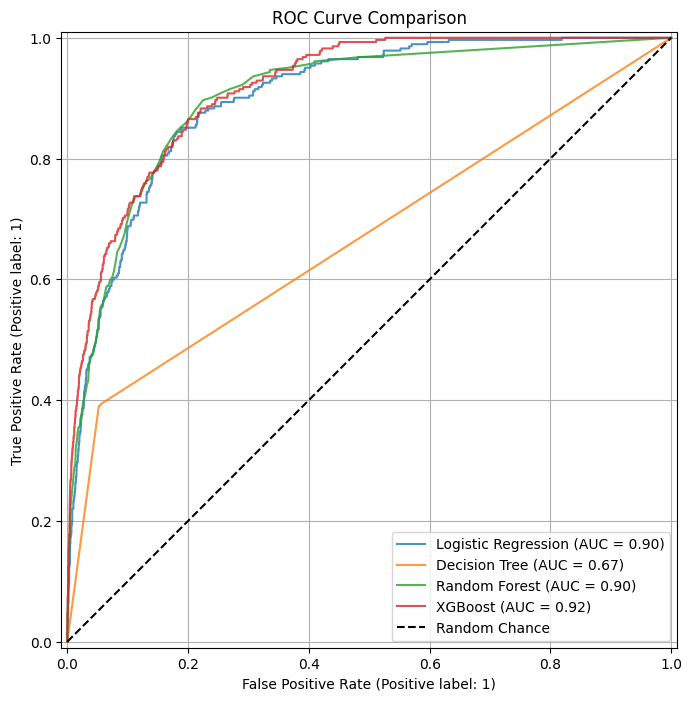


--- Model Comparison ---
                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.824313   0.236125  0.829787  0.367636  0.900108
Random Forest        0.932562   0.450185  0.432624  0.441230  0.901797
XGBoost              0.946966   0.600000  0.414894  0.490566  0.915743
Decision Tree        0.913575   0.329341  0.390071  0.357143  0.669533


In [10]:
print("\n--- Training Classification Models ---")

# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42), # liblinear good for smaller datasets
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1), # Use all CPU cores
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1) # eval_metric to suppress warning
}

# Dictionary to store trained models and results
trained_models = {}
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train on the SMOTE-resampled data
    model.fit(X_train_smote, y_train_smote)

    # Make predictions on the ORIGINAL UNSEEN test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }
    trained_models[name] = model # Store the trained model instance

    print(f"{name} Training Complete.")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}") # Recall is often important for imbalanced classes
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Print Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Display ROC Curves for all models
plt.figure(figsize=(10, 8))
ax = plt.gca()
for name, model in trained_models.items():
    try:
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=ax, alpha=0.8)
    except Exception as e:
         print(f"Could not plot ROC curve for {name}: {e}") # Handle models without predict_proba if needed
plt.title('ROC Curve Comparison')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Add diagonal line
plt.legend()
plt.grid(True)
plt.show()


# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T # Transpose to have models as rows
print("\n--- Model Comparison ---")
print(results_df.sort_values(by='Recall', ascending=False)) # Sort by Recall or F1-score, as accuracy can be misleading

In [12]:
# --- Select and Save Best Model ---
# Choose the best model based on metrics (e.g., highest Recall or F1)
# Let's say Random Forest performed best based on Recall/F1
best_model_name = results_df['Recall'].idxmax() # Or results_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]

print(f"\nSelected Best Model: {best_model_name}")

# Define path for saving the model
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True) # Ensure directory exists
model_save_path = os.path.join(output_dir, 'best_classification_model.joblib')

# Save the model
joblib.dump(best_model, model_save_path)
print(f"Best classification model saved to: {model_save_path}")


Selected Best Model: Logistic Regression
Best classification model saved to: models\best_classification_model.joblib
